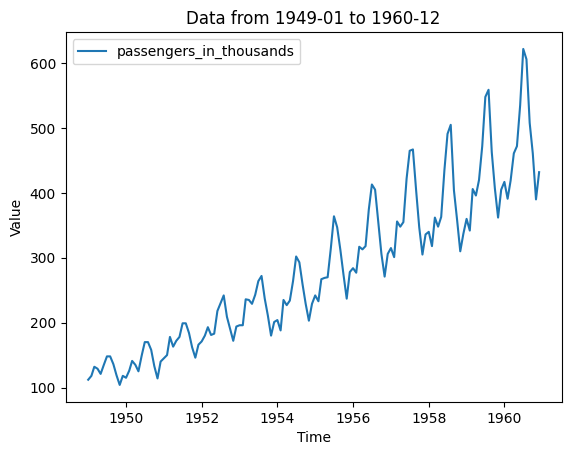

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/airline/airline.csv')

def plot_csv_by_time(csv_path, start_time, end_time):
    # Load CSV file into a pandas dataframe
    df = pd.read_csv(csv_path,parse_dates=['Month'],  index_col=['Month'])
    
    # Select rows within the specified time range
    df = df.loc[start_time:end_time]
    
    # Generate a line plot for each column in the dataframe
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    
    # Set plot title and axis labels
    plt.title(f"Data from {start_time} to {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    # Display legend and show plot
    plt.legend()
    plt.show()


plot_csv_by_time('data/airline/airline.csv', '1949-01', '1960-12')

In [1]:
import torch
import pandas as pd
from src.utils import load_checkpoint
from src.scaler import Scaler
from src.dataset import TimeSeriesDataset
from src.forecast_models import LSTMForecaster
from src.train import train, inference

input_field = ['passengers_in_thousands']
output_field = ['passengers_in_thousands']
timeseries_field = list(set(input_field + output_field))
datasetPath = 'data/airline'
t = 16
h = 4

if torch.cuda.is_available():
    device =  torch.device('cuda')
else:
    device =  torch.device('cpu')

train_df = pd.read_csv(f'{datasetPath}/train.csv')
test_df = pd.read_csv(f'{datasetPath}/test.csv')
val_df = pd.read_csv(f'{datasetPath}/val.csv')
scaler = Scaler(train_df[timeseries_field], 'minmax')

train_dataset = TimeSeriesDataset(train_df, input_field, output_field, t=t, h=h, scaler=scaler)
test_dataset = TimeSeriesDataset(test_df, input_field, output_field, t=t, h=h, scaler=scaler)
val_dataset = TimeSeriesDataset(val_df, input_field, output_field, t=t, h=h, scaler=scaler)

modelPath = 'out/LSTMForecaster_airline/n1_hs128_h4_t16/best.pth.tar'
model = LSTMForecaster(input_size=len(input_field), output_size=len(output_field)*h, hidden_size=128, num_layers=1)
model.to(device)

load_checkpoint(modelPath, model)

criterion = torch.nn.L1Loss()

inference(test_dataset, model, criterion, device=device, batch_size=8)

=> loaded checkpoint 'True' (epoch 731)
Checkpoint's train loss is: 0.2228
Checkpoint's validation loss is: 0.0581


0.5341048240661621

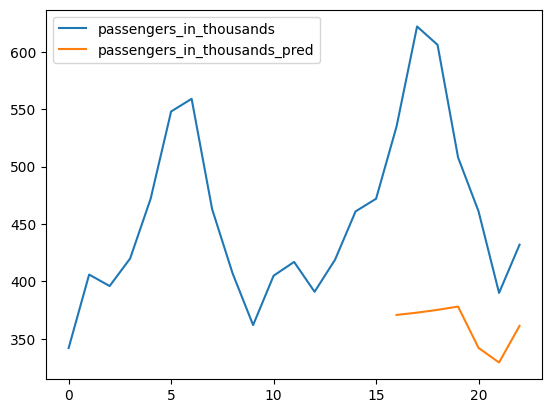

In [2]:
test_dataset.predict(model)
test_dataset.plot_forecast_result()

In [3]:
import pandas as pd
from pmdarima.arima import auto_arima
from src.dataset import TimeSeriesDataset

input_field = ['passengers_in_thousands']
output_field = ['passengers_in_thousands']

train_data = pd.read_csv('data/airline/train.csv', parse_dates=['Month'], index_col=['Month'])
val_data = pd.read_csv('data/airline/val.csv', parse_dates=['Month'], index_col=['Month'])
test_data = pd.read_csv('data/airline/test.csv', parse_dates=['Month'], index_col=['Month'])

train_data = pd.concat([train_data, val_data]) # As this is ARIMA, we dont need validation set

train_dataset = TimeSeriesDataset(train_data, input_field, output_field, scaler=None)
test_dataset = TimeSeriesDataset(test_data, input_field, output_field, scaler=None)

model = auto_arima(train_dataset.data, seasonal=True)  # Adjust the order according to your data
model_fit = model.fit(train_dataset.data)

# Forecasting the future values
forecast = model_fit.predict(n_periods=len(test_dataset.data))

# Printing the forecasted values
print(forecast)

1959-02-01    374.388368
1959-03-01    393.887361
1959-04-01    413.470157
1959-05-01    428.577171
1959-06-01    436.266031
1959-07-01    435.825631
1959-08-01    428.745429
1959-09-01    418.110774
1959-10-01    407.638670
1959-11-01    400.641763
1959-12-01    399.199176
1960-01-01    403.731441
1960-02-01    413.051658
1960-03-01    424.833112
1960-04-01    436.330231
1960-05-01    445.139186
1960-06-01    449.794880
1960-07-01    450.063718
1960-08-01    446.884995
1960-09-01    442.010491
1960-10-01    437.466107
1960-11-01    434.994032
1960-12-01    435.623582
Freq: MS, dtype: float64


In [20]:
from src.forecast_strategy import LSTMStrategy

input_field = ['passengers_in_thousands']
output_field = ['passengers_in_thousands']
h = 4
t = 16

modelPath = 'out/LSTMForecaster_airline/n1_hs16_h4_t16/best.pth.tar'
lstmforecaster = LSTMStrategy(modelPath, 1, 16, t)
lstmforecaster.load_data('data/airline/airline.csv')
df = lstmforecaster.forecast(output_field, input_field, h)

=> loaded checkpoint 'True' (epoch 6960)
Checkpoint's train loss is: 0.1783
Checkpoint's validation loss is: 0.1705


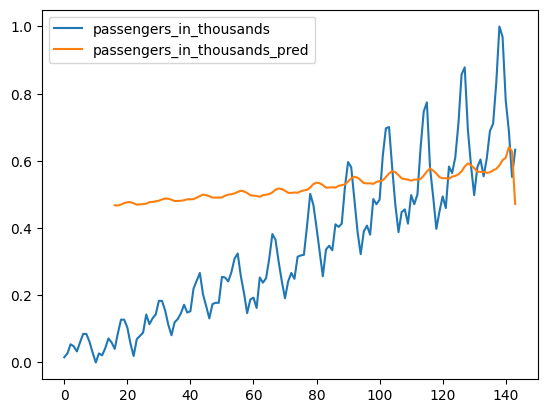

In [21]:
import matplotlib.pyplot as plt

cols = ['passengers_in_thousands', 'passengers_in_thousands_pred']
for col in cols:
    plt.plot(df[col], label=col)
plt.legend()
plt.show()


In [15]:
df.iloc[16:48]

,Month,passengers_in_thousands,passengers_in_thousands_pred
16,NaN,0.040541,0.107402
17,NaN,0.086873,0.107213
18,NaN,0.127413,0.107637
19,NaN,0.127413,0.108418
20,NaN,0.104247,0.108862
21,NaN,0.055985,0.108762
22,NaN,0.019305,0.108047
23,NaN,0.069498,0.107168
24,NaN,0.079151,0.107305
25,NaN,0.088803,0.107601
